### Setup & Imports

In [130]:
import os
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack, csr_matrix, save_npz
from scipy import sparse

### Load dataset

In [131]:
df = pd.read_csv('processed_reviews.csv')

print("Initial dataset shape:", df.shape)
print(df.head())

Initial dataset shape: (40432, 3)
  label                                             review  \
0    CG  Love this!  Well made, sturdy, and very comfor...   
1    CG  love it, a great upgrade from the original.  I...   
2    CG  This pillow saved my back. I love the look and...   
3    CG  Missing information on how to use it, but it i...   
4    CG  Very nice set. Good quality. We have had the s...   

                                    processed_review  
0  ['love', 'well', 'made', 'sturdy', 'comfortabl...  
1  ['love', 'great', 'upgrade', 'original', 'ive'...  
2  ['pillow', 'saved', 'back', 'love', 'look', 'f...  
3  ['missing', 'information', 'use', 'great', 'pr...  
4  ['nice', 'set', 'good', 'quality', 'set', 'two...  


### Convert string representation of tokens back to list

In [132]:
df['processed_review'] = df['processed_review'].apply(lambda x: ast.literal_eval(x))

print("\nSample processed review tokens:", df['processed_review'].iloc[0])
print("Type:", type(df['processed_review'].iloc[0]))


Sample processed review tokens: ['love', 'well', 'made', 'sturdy', 'comfortable', 'love', 'itvery', 'pretty']
Type: <class 'list'>


## Feature Extraction

### Review Length

In [133]:
df['review_length'] = df['processed_review'].apply(len)

print("\nReview length stats:")
print(df['review_length'].describe())


Review length stats:
count    40432.000000
mean        32.086837
std         33.654014
min          0.000000
25%         10.000000
50%         18.000000
75%         40.000000
max        237.000000
Name: review_length, dtype: float64


### Prepare text for vectorizers

In [134]:
# Join tokens into a single string
df['processed_text'] = df['processed_review'].apply(lambda tokens: ' '.join(tokens))

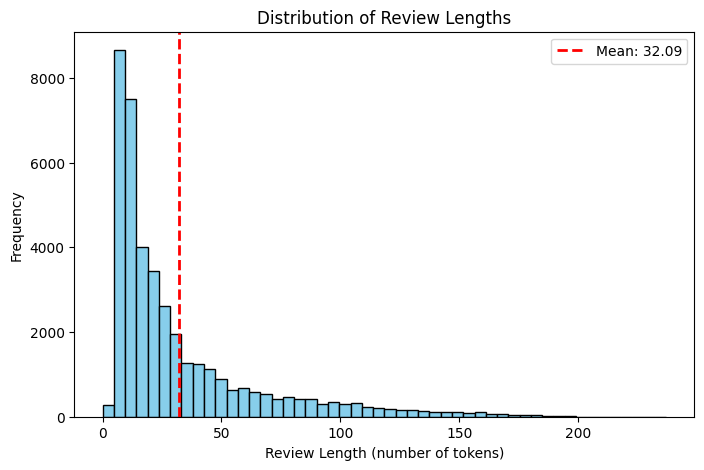

In [135]:
# Visualization: Distribution of review lengths

plt.figure(figsize=(8,5))
plt.hist(df['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(df['review_length'].mean(), color='red', linestyle='dashed', linewidth=2,
            label=f'Mean: {df["review_length"].mean():.2f}')
plt.title("Distribution of Review Lengths")
plt.xlabel("Review Length (number of tokens)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

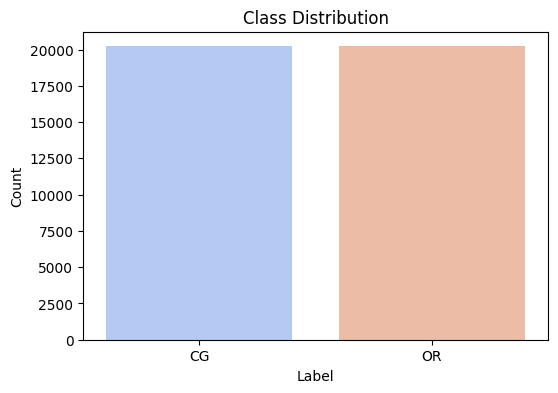

In [136]:
# Visualization: Class Distribution
if 'label' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x='label', hue='label', palette='coolwarm', legend=False)
    plt.title('Class Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

### N-grams (Unigrams + Bigrams) with Feature Limiting

In [137]:
vectorizer = CountVectorizer(
    ngram_range=(1, 2),    # unigrams and bigrams
    max_features=10000,    # keep only the top 10,000 terms
    min_df=5               # ignore words appearing in <5 reviews
)

# Keep this sparse to avoid memory issues
ngram_features = vectorizer.fit_transform(df['processed_text'])

print("N-gram sparse matrix shape:", ngram_features.shape)

N-gram sparse matrix shape: (40432, 10000)


### TF-IDF with Feature Limiting

In [138]:
tfidf = TfidfVectorizer(
    max_features=10000,   # top 10,000 terms only
    min_df=5,             # ignore words appearing in <5 reviews
    ngram_range=(1, 2)    # unigrams and bigrams
)

# Keep this sparse as well
tfidf_features = tfidf.fit_transform(df['processed_text'])

print("TF-IDF sparse matrix shape:", tfidf_features.shape)

# Save the fitted TF-IDF vectorizer for future use
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("TF-IDF vectorizer saved as tfidf_vectorizer.pkl")

TF-IDF sparse matrix shape: (40432, 10000)
TF-IDF vectorizer saved as tfidf_vectorizer.pkl


### Combine Review Length + TF-IDF

In [139]:
# Convert review_length to sparse matrix
review_length_sparse = csr_matrix(df['review_length'].values.reshape(-1, 1))

# Combine TF-IDF features with review_length
final_features = hstack([tfidf_features, review_length_sparse])

print("Final combined feature matrix shape:", final_features.shape)

Final combined feature matrix shape: (40432, 10001)


### Save TF-IDF Vocabulary for Future Use

In [140]:
# Save vocabulary to keep consistent features for model deployment
vocab_path = "tfidf_vocabulary.csv"
pd.DataFrame(tfidf.get_feature_names_out(), columns=['term']).to_csv(vocab_path, index=False)
print(f"TF-IDF vocabulary saved to {vocab_path}")

TF-IDF vocabulary saved to tfidf_vocabulary.csv


### Save sparse matrix

In [141]:
sparse.save_npz("final_features_sparse.npz", final_features)
print("Sparse feature matrix saved to final_features_sparse.npz")

Sparse feature matrix saved to final_features_sparse.npz
